# Sentinel-2 data

In [1]:
import os
import fiona
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import matplotlib.pyplot as plt
import geopandas as gpd
import mapclassify
import numpy as np

In [3]:
files = os.listdir(r"C:\Users\User\Documents\UNITN\Geospatial\raster\plovdiv\jp2")
files

['T35TLG_20221007T090851_B01.jp2',
 'T35TLG_20221007T090851_B02.jp2',
 'T35TLG_20221007T090851_B03.jp2',
 'T35TLG_20221007T090851_B04.jp2',
 'T35TLG_20221007T090851_B05.jp2',
 'T35TLG_20221007T090851_B06.jp2',
 'T35TLG_20221007T090851_B07.jp2',
 'T35TLG_20221007T090851_B08.jp2',
 'T35TLG_20221007T090851_B09.jp2',
 'T35TLG_20221007T090851_B10.jp2',
 'T35TLG_20221007T090851_B11.jp2',
 'T35TLG_20221007T090851_B12.jp2']

In [2]:
municipalities = gpd.read_file("C:\\Users\\User\\Documents\\UNITN\\Geospatial\\raster\\municipalities.geojson")
municipalities.crs #4326
plovdiv_city = municipalities[municipalities.nuts4 == "PDV22"]

In [3]:
plovdiv_city.to_crs(32635).area/10**6 #total area

260    101.201118
dtype: float64

In [4]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

coords = getFeatures(plovdiv_city.to_crs(epsg=32635))

### Create jp2 for each band clipped for Plovdiv

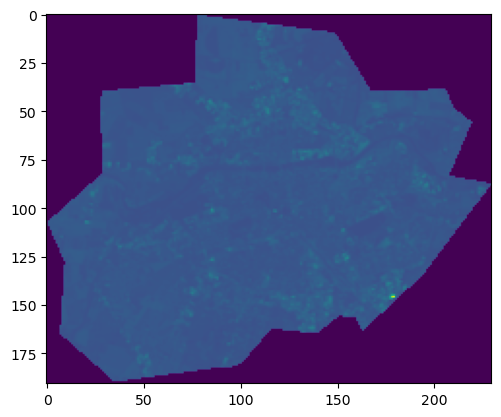

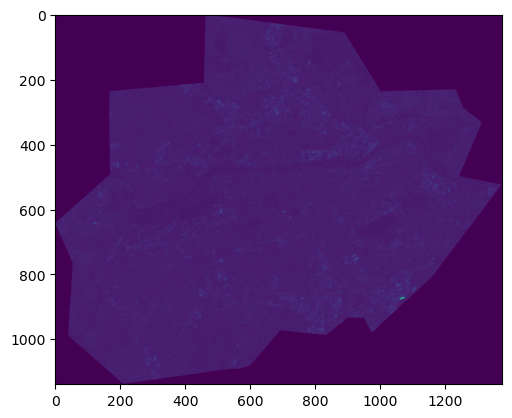

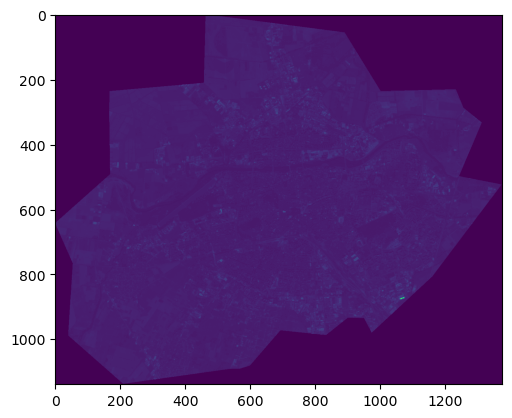

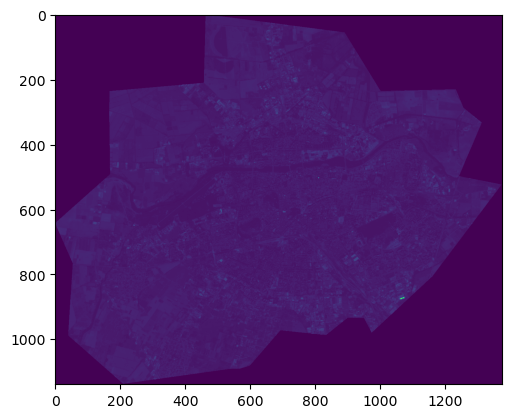

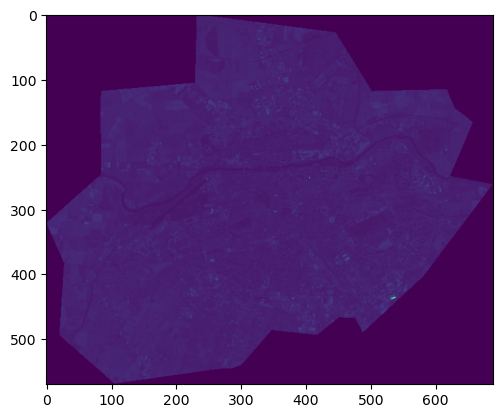

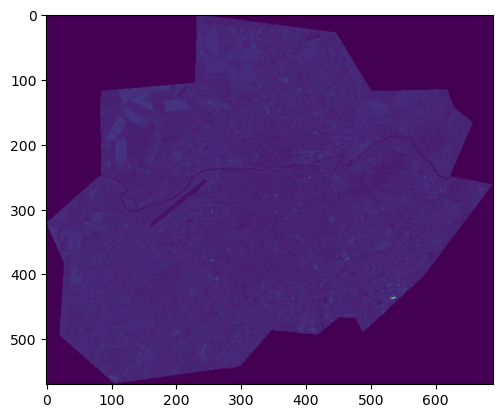

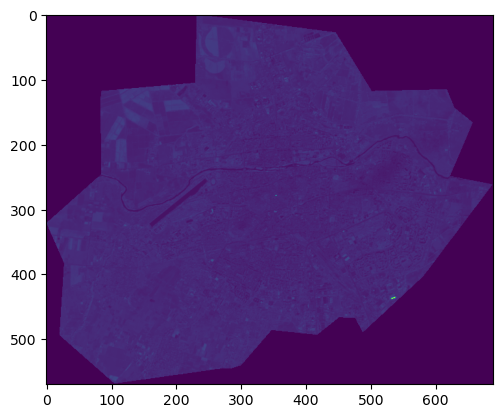

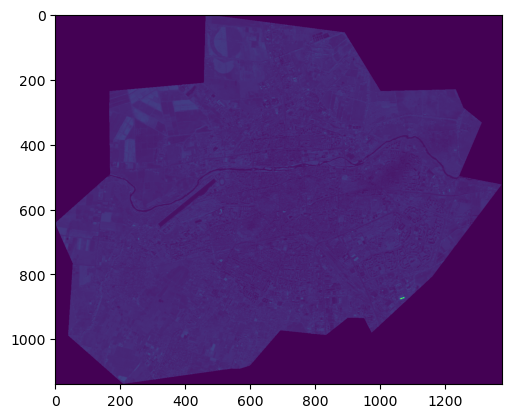

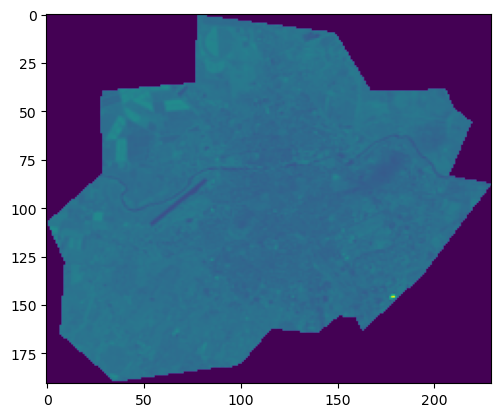

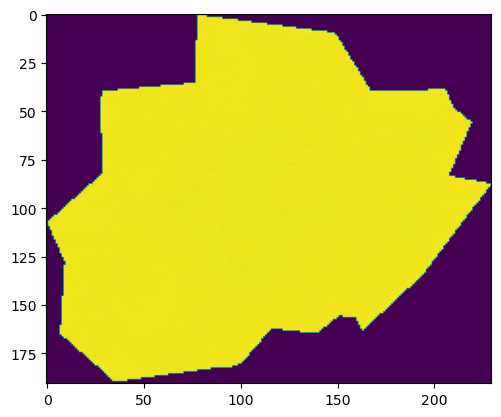

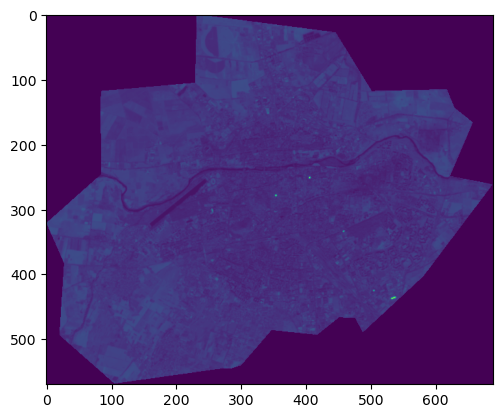

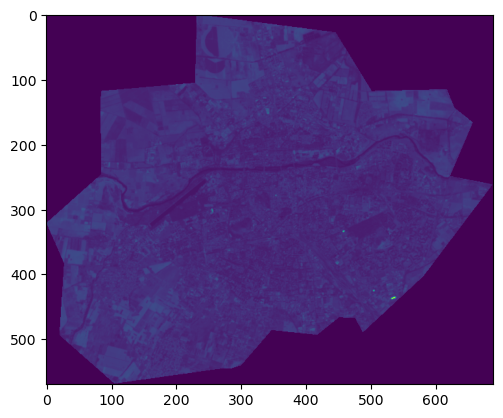

In [28]:
out_images_transforms_meta = []

for i in range(len(files)):
    bandName = files[i]
    rasterPath = os.path.join("C:\\Users\\User\\Documents\\UNITN\\Geospatial\\raster\\plovdiv\\jp2",bandName)
    rasterBand = rasterio.open(rasterPath)

    out_img, out_transform = mask(rasterBand, coords, crop=True)
    out_meta = rasterBand.meta
    #show(out_img)
    j = i+1
    with rasterio.open(f"C:\\Users\\User\\Documents\\UNITN\\Geospatial\\raster\\plovdiv\\jp2_cropped\\ortophoto_plovdiv_cropped_band{j}.jp2", "w", **out_meta) as dest:
        dest.write(out_img)


    #out_images_transforms_meta.append((out_img, out_transform, out_meta))

## JP2 cropped

In [5]:
bandNames = ['ortophoto_plovdiv_cropped_band1.jp2',
 'ortophoto_plovdiv_cropped_band2.jp2',
 'ortophoto_plovdiv_cropped_band3.jp2',
 'ortophoto_plovdiv_cropped_band4.jp2',
 'ortophoto_plovdiv_cropped_band5.jp2',
 'ortophoto_plovdiv_cropped_band6.jp2',
 'ortophoto_plovdiv_cropped_band7.jp2',
 'ortophoto_plovdiv_cropped_band8.jp2',
 'ortophoto_plovdiv_cropped_band9.jp2',
  'ortophoto_plovdiv_cropped_band10.jp2',
 'ortophoto_plovdiv_cropped_band11.jp2',
 'ortophoto_plovdiv_cropped_band12.jp2']

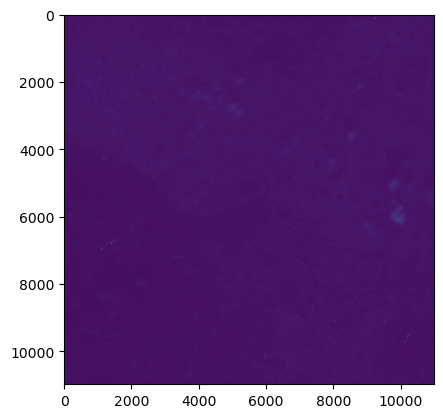

In [15]:
b2 = rasterio.open(os.path.join("C:\\Users\\User\\Documents\\UNITN\\Geospatial\\raster\\plovdiv\\jp2",files[1]))
show(b2.read(1))

# Computing some indices

https://gisgeography.com/sentinel-2-bands-combinations/

## NDVI

The Normalized Difference Vegetation Index (NDVI) is a numerical indicator that uses the red and near-infrared spectral bands. NDVI is highly associated with vegetation content. High NDVI values correspond to areas that reflect more in the near-infrared spectrum. Higher reflectance in the near-infrared correspond to denser and healthier vegetation.

https://www.usgs.gov/special-topics/remote-sensing-phenology/science/ndvi-foundation-remote-sensing-phenology

In [18]:
band8 = rasterio.open("C:\\Users\\User\\Documents\\UNITN\\Geospatial\\raster\\plovdiv\\jp2_cropped\\ortophoto_plovdiv_cropped_band8.jp2").read(1)
band4 = rasterio.open("C:\\Users\\User\\Documents\\UNITN\\Geospatial\\raster\\plovdiv\\jp2_cropped\\ortophoto_plovdiv_cropped_band4.jp2").read(1)
ndvi = (band8.astype(float)-band4.astype(float))/(band8.astype(float)+band4.astype(float))

C:\Users\User\AppData\Local\Temp\ipykernel_21188\1096861891.py:3: RuntimeWarning: invalid value encountered in divide
  ndvi = (band8.astype(float)-band4.astype(float))/(band8.astype(float)+band4.astype(float))


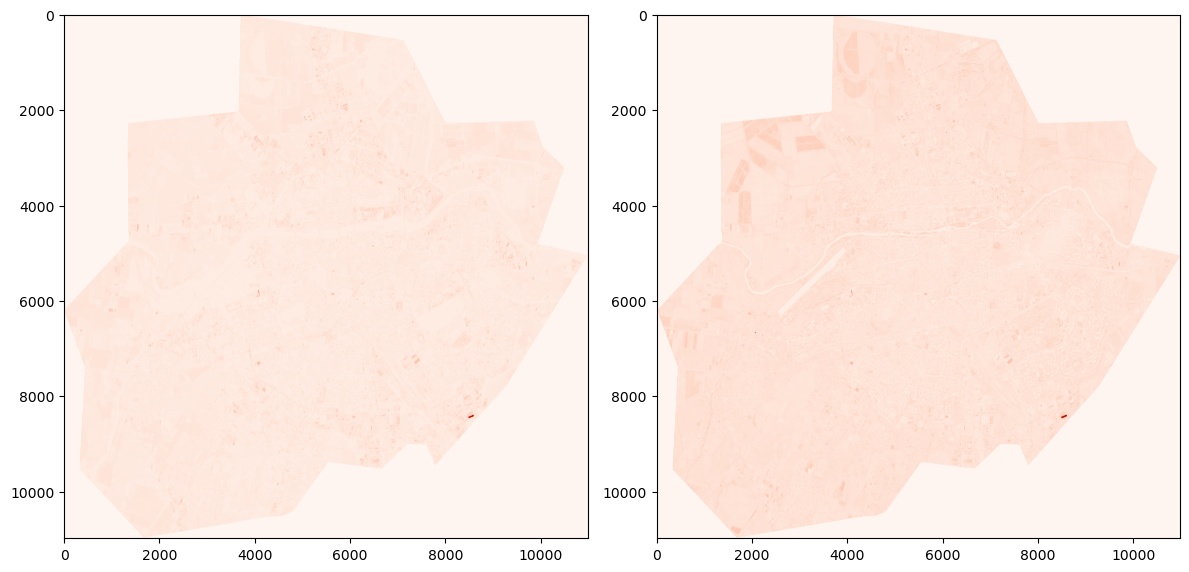

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
show(band4, ax=ax1, cmap='Reds') #red
show(band8, ax=ax2, cmap='Reds') #nir
fig.tight_layout()

In [20]:
print('\nMax NDVI: {m}'.format(m=np.nanmax(ndvi)))
print('Mean NDVI: {m}'.format(m=np.nanmean(ndvi)))
print('Median NDVI: {m}'.format(m=np.nanmedian(ndvi)))
print('Min NDVI: {m}'.format(m=np.nanmin(ndvi)))


Max NDVI: 1.0
Mean NDVI: 0.18088510016463197
Median NDVI: 0.1708041587099512
Min NDVI: -1.0


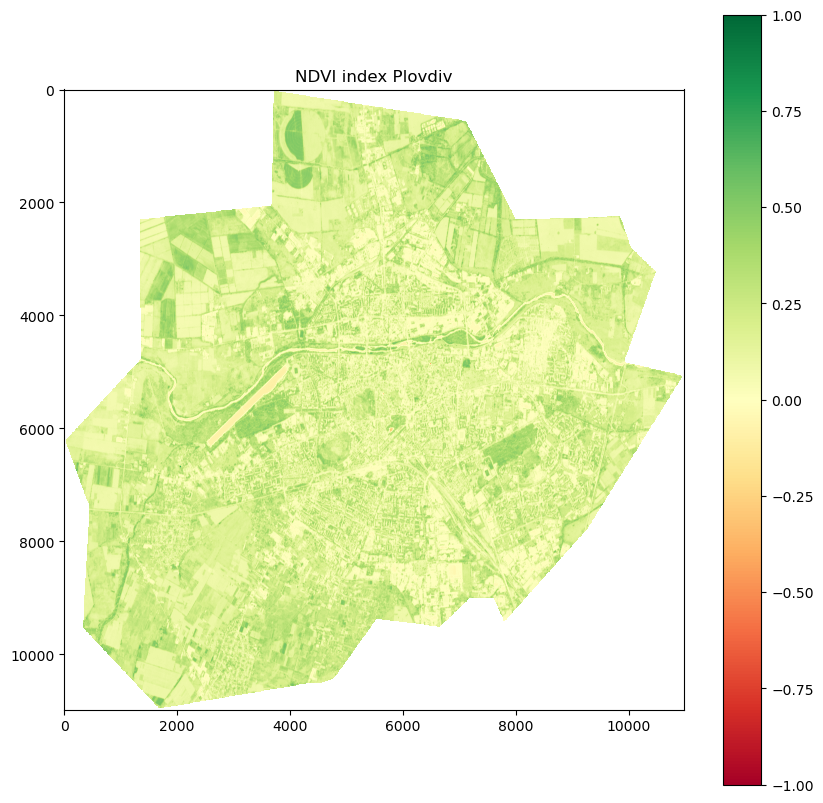

In [22]:
plt.figure(figsize = (10,10))
plt.imshow(ndvi, cmap="RdYlGn")
plt.colorbar()
plt.title("NDVI index Plovdiv")
plt.show()

Text(0.5, 1.0, 'NDVI index histogram')

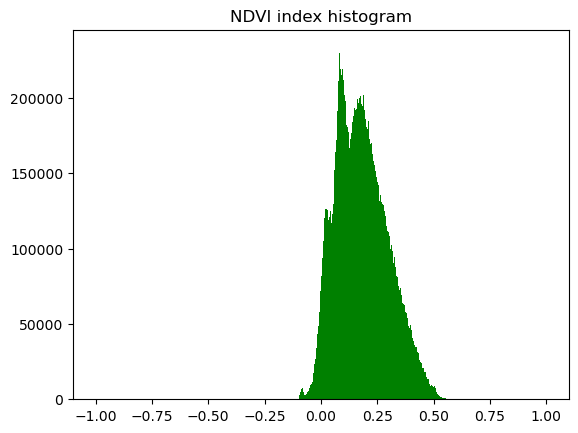

In [23]:
import numpy as np
plt.hist(ndvi[~np.isnan(ndvi)], bins='auto', color="green")
plt.title("NDVI index histogram")

What can further be done is for example filter areas with a certain value of the NDVI index.

In [70]:
import copy
ndvi_gtpt2 = copy.copy(ndvi)
#keeping only values < 0.2
ndvi_gtpt2[ndvi>0.2] = np.nan  
print('Mean NDVI < 0.2:',round(np.nanmean(ndvi_gtpt2),2))

Mean NDVI < 0.2: 0.1


## Moisture

The moisture index is ideal for finding water stress in plants. It uses the short-wave and near-infrared to generate an index of moisture content. In general, wetter vegetation has higher values. But lower moisture index values suggest plants are under stress from insufficient moisture.

Since the resolution of bands is different, they need to be rescaled for the following graphs in order ot match.

In [32]:
# Rescaling bands 2 and 8

from rasterio.enums import Resampling

upscale_factor = 0.5

with rasterio.open("C:\\Users\\User\\Documents\\UNITN\\Geospatial\\raster\\plovdiv\\jp2_cropped\\ortophoto_plovdiv_cropped_band8.jp2") as dataset:

    # resample data to target shape
    data = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )

    # scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )



In [44]:
# Rescaling

with rasterio.open("C:\\Users\\User\\Documents\\UNITN\\Geospatial\\raster\\plovdiv\\jp2_cropped\\ortophoto_plovdiv_cropped_band2.jp2") as dataset:

    # resample data to target shape
    data2 = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )

    # scale image transform
    transform2 = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )

In [45]:
data2.shape

(1, 5490, 5490)

C:\Users\User\AppData\Local\Temp\ipykernel_21188\4055992305.py:4: RuntimeWarning: invalid value encountered in divide
  moist = (band8_20m.astype(float)-band11.astype(float))/(band8_20m.astype(float)+band11.astype(float))


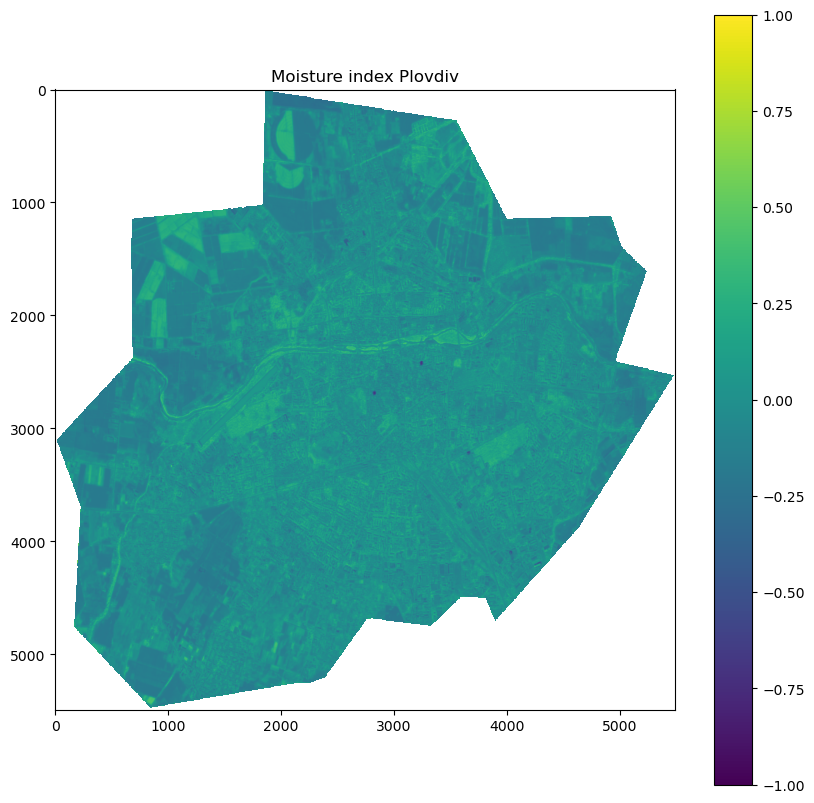

In [43]:
band8_20m = data[0]
band11 = rasterio.open("C:\\Users\\User\\Documents\\UNITN\\Geospatial\\raster\\plovdiv\\jp2_cropped\\ortophoto_plovdiv_cropped_band11.jp2").read(1)

moist = (band8_20m.astype(float)-band11.astype(float))/(band8_20m.astype(float)+band11.astype(float))

plt.figure(figsize = (10,10))
plt.imshow(moist)
plt.colorbar()
plt.title("Moisture index Plovdiv")
plt.show()

Text(0.5, 1.0, 'Moisture index histogram')

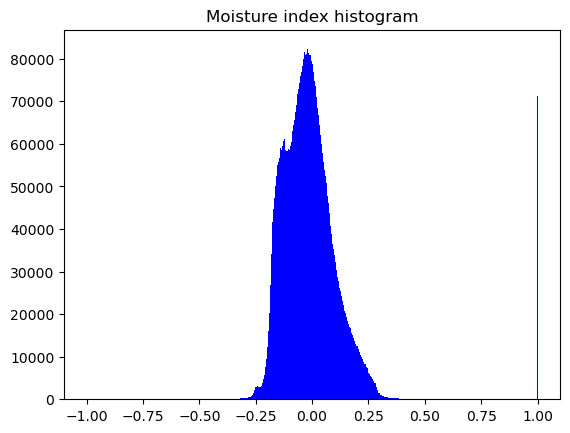

In [42]:
plt.hist(moist[~np.isnan(moist)], bins='auto', color="blue")
plt.title("Moisture index histogram")

## Agriculture representation


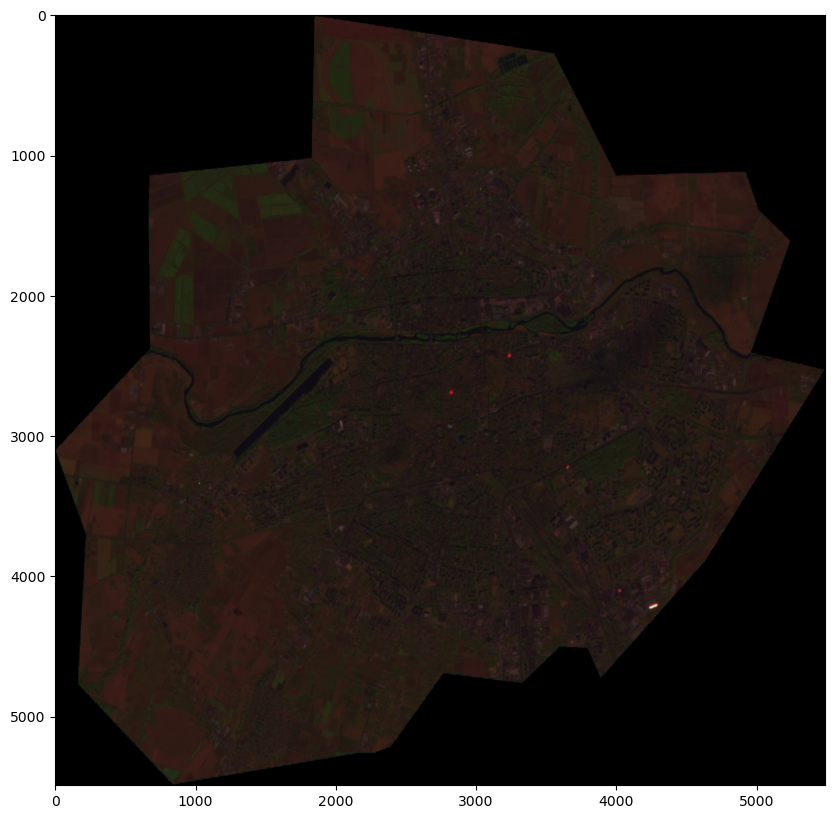

In [46]:
b11 = band11.copy
b8 = band8_20m.copy
b2 = data2[0]

def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band-band_min)/((band_max - band_min)))

b11_n = normalize(b11)
b8_n = normalize(b8)
b2_n = normalize(b2)

plt.figure(figsize = (10,10))
agri_norm= np.dstack((b11_n, b8_n, b2_n))
plt.imshow(agri_norm)

# Bathymetric

As the name implies, the bathymetric band combination is good for coastal studies. The bathymetric band combination uses the red (B4), green (B3), and coastal band (B1). Using the coastal aerosol band is good for estimating suspended sediment in the water.

In [53]:
# Rescaling b1
upscale_factor = 6
with rasterio.open("C:\\Users\\User\\Documents\\UNITN\\Geospatial\\raster\\plovdiv\\jp2_cropped\\ortophoto_plovdiv_cropped_band1.jp2") as dataset:

    # resample data to target shape
    data1 = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )

    # scale image transform
    transform1 = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )

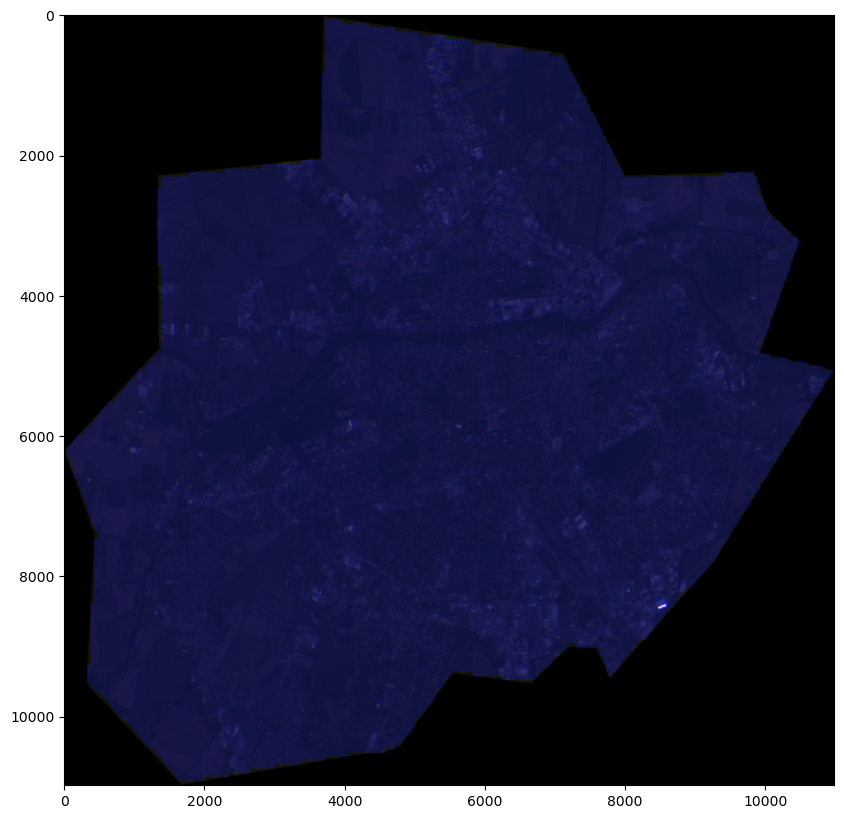

In [57]:
b4 = band4
b3 = rasterio.open("C:\\Users\\User\\Documents\\UNITN\\Geospatial\\raster\\plovdiv\\jp2_cropped\\ortophoto_plovdiv_cropped_band2.jp2").read(1)
b1 = data1[0]

b4_n = normalize(b4)
b3_n = normalize(b3)
b1_n = normalize(b1)

plt.figure(figsize = (10,10))
bathy_n= np.dstack((b4_n, b3_n, b1_n))
plt.imshow(bathy_n)

## Geology (B12, B11, B2)

The geology band combination is a neat application for finding geological features. This includes faults, lithology, and geological formations.

In [ ]:
# Rescaling b2
upscale_factor = 1/2
with rasterio.open("C:\\Users\\User\\Documents\\UNITN\\Geospatial\\raster\\plovdiv\\jp2_cropped\\ortophoto_plovdiv_cropped_band2.jp2") as dataset:

    # resample data to target shape
    data2 = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )

    # scale image transform
    transform2 = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )

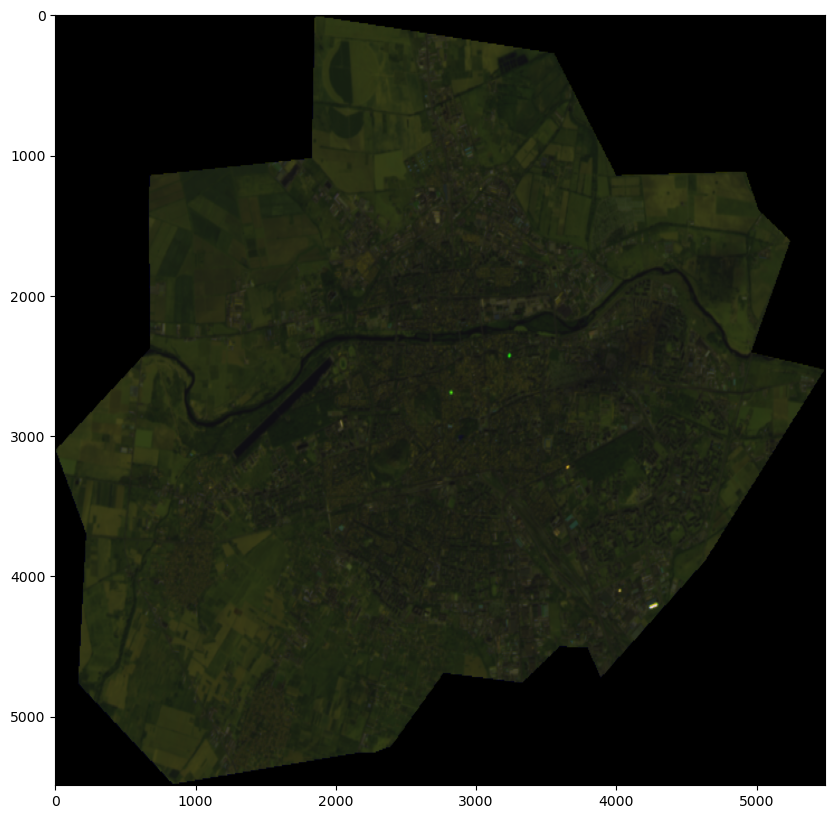

In [59]:
b11 = rasterio.open("C:\\Users\\User\\Documents\\UNITN\\Geospatial\\raster\\plovdiv\\jp2_cropped\\ortophoto_plovdiv_cropped_band11.jp2").read(1)
b12 = rasterio.open("C:\\Users\\User\\Documents\\UNITN\\Geospatial\\raster\\plovdiv\\jp2_cropped\\ortophoto_plovdiv_cropped_band12.jp2").read(1)
b2 = data2[0]

b11_n = normalize(b11)
b12_n = normalize(b12)
b2_n = normalize(b2)

plt.figure(figsize = (10,10))
geology_n= np.dstack((b12_n, b11_n, b2_n))
plt.imshow(geology_n)